# Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [11]:
import os
!ls
if not os.path.exists('birds21sp'):
    !mkdir birds21sp
    os.chdir('birds21sp')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

drive  sample_data
--2021-06-12 09:35:06--  https://pjreddie.com/media/files/birds/train.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7970048512 (7.4G) [application/octet-stream]
Saving to: ‘train.tar’

train.tar           100%[===================>]   7.42G  42.4MB/s    in 5m 50s  

2021-06-12 09:40:57 (21.7 MB/s) - ‘train.tar’ saved [7970048512/7970048512]

--2021-06-12 09:40:57--  https://pjreddie.com/media/files/birds/test.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2057210880 (1.9G) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]   1.92G  40.9MB/s    in 49s     

2021-06-12 09:41:46 (40.3 MB/s) - ‘test.tar’ saved [2057210880/2057210880]

--2021-06-12

In [12]:
def get_bird_data(augmentation=0):
    # Normalizing input according to https://pytorch.org/vision/stable/models.html
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform_train = transforms.Compose([
        # H and W are expected to be at least 224 - doubled from original 128
        transforms.Resize(256),
        transforms.RandomCrop(256, padding=8, padding_mode='edge'), # Take 256x256 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
        normalize,
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        normalize,
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds21sp/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21sp/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21sp/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [13]:
print(data['to_class'])
print(data['to_name'])

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 256, 256])


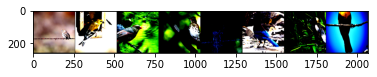

Labels:Lark Bunting (Female/Nonbreeding male), American Goldfinch (Female/Nonbreeding Male), Northern Cardinal (Female/Juvenile), Wood Thrush, Eastern Wood-Pewee, Steller's Jay, Bobolink (Breeding male), Yellow-headed Blackbird (Adult Male)


In [15]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

# Training

In [18]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [25]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

losses = train(resnet, data['train'], epochs=12, schedule={0:.1, 1:.01, 8:.001}, checkpoint_path=checkpoints)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Learning rate: 0.100000
[0,    10] loss: 6.500
[0,    20] loss: 6.167
[0,    30] loss: 5.695
[0,    40] loss: 5.222
[0,    50] loss: 4.950
[0,    60] loss: 4.677
[0,    70] loss: 4.530
[0,    80] loss: 4.397
[0,    90] loss: 4.150
[0,   100] loss: 3.967
[0,   110] loss: 3.923
[0,   120] loss: 3.835
[0,   130] loss: 3.730
[0,   140] loss: 3.534
[0,   150] loss: 3.618
[0,   160] loss: 3.415
[0,   170] loss: 3.365
[0,   180] loss: 3.369
[0,   190] loss: 3.198
[0,   200] loss: 3.220
[0,   210] loss: 3.213
[0,   220] loss: 3.119
[0,   230] loss: 2.999
[0,   240] loss: 2.945
[0,   250] loss: 3.089
[0,   260] loss: 3.008
[0,   270] loss: 2.943
[0,   280] loss: 2.850
[0,   290] loss: 2.950
[0,   300] loss: 2.787
Learning rate: 0.010000
[1,    10] loss: 2.532
[1,    20] loss: 2.273
[1,    30] loss: 2.101
[1,    40] loss: 1.902
[1,    50] loss: 1.922
[1,    60] loss: 1.816
[1,    70] loss: 1.802
[1,    80] loss: 1.762
[1,    90] loss: 1.739
[1,   100] loss: 1.801
[1,   110] loss: 1.732
[1,   120

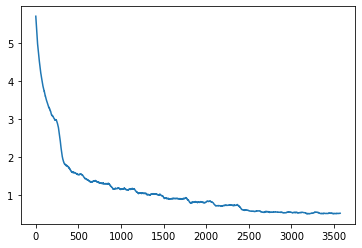

In [26]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

# Training Accuracy

In [27]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

print("Training accuracy: %f" % accuracy(resnet, data['train']))
# Ignore testing accuracy - we realized it doesn't work cause test data isn't labeled
print("Testing  accuracy: %f" % accuracy(resnet, data['test']))

Training accuracy: 0.903299
Testing  accuracy: 0.001200


# Prediction

In [29]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [30]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-12.pkl')
resnet.load_state_dict(state['net'])


predict(resnet, data['test'], checkpoints + "preds.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [ ]:
# need to split files


# Validation (unused)
This was supposed to be for validation, but we ended up not re-running with this version (I did test to make sure these Linux commands worked though - these code snippets need to be run before `get_bird_data` and we just add another set/loader for validation).

In [ ]:
# make validation folder and all the subdirectories (0-554 for each bird type)
if not os.path.exists('validation'):
  !mkdir validation
  os.chdir('validation')
  !for ((i = 0; i < 555; i++)); do mkdir $i; done
  os.chdir('..')

In [ ]:
# randomly move a few random files from training set to validation 
os.chdir('train')
!for ((i = 0; i < 555; i++)); do cd $i; ls | shuf -n 3 | xargs -i mv {} ../../validation/$i; cd ..; done
os.chdir('..')